# Neural Network Project
### Authors: Ryan Hilton, Adam Bobok, Anish Gadgil, Steven Li

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import pi, e, exp
import math
from random import sample
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import os
import shutil
from tabulate import tabulate

## Binary Classification Neural Network

The following code is an implementation of the multilayer perceptron (MLP), aka Neural Network. This implementation utilizes a tanh activation function, as well as Stochastic Gradient Descent (SGD).

### Activation Functions

The tanh function is expressed as:

\begin{align*}
tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
\end{align*}

The derivative of the tanh function is expressed as:

\begin{align*}
tanh'(x) = 1 - (tanh(x))^2
\end{align*}

In [2]:
def tanh(a):
    return np.tanh(a)

def tanh_prime(x):
    return 1-np.tanh(x)**2

### Classification

The sigmoid function, $\sigma(x)$, is expressed as:

\begin{align*}
\hat{y} = \sigma(x) = \frac{1}{1 + e^{-x}}
\end{align*}

The output from $\sigma(x)$ is then an input into our binary step function, which is expressed as:

\begin{array}{rcl}
\mbox{f($\hat{y}$) =} & 1 & \mbox{for}
& \hat{y}>0.5 \\ \mbox{} & 0 & \mbox{for} & \hat{y}\leq0.5\\
\end{array}

In [3]:
def sigmoid(a):
    return 1.0 / (1.0 + exp(-a))

def sigmoid_prime(x):
    return sigmoid(x)*(1-sigmoid(x))

def binary_step(prob):
    if prob > 0.5: #0 for tanh classification, 0.5 for sigmoid classification
        return 1.0
    return 0.0

"""
The use of the two functions below only makes sense if you one-hot-encode your Y data as well as implement the
multiclass variant of cross entropy.
"""
def softmax(X):
    e_X = exp(X)
    return e_X / np.sum(e_X)

def multiclass_classification(PROBS):
    result = np.zeros(np.shape(PROBS))
    result[PROBS.index(max(PROBS))] = 1
    return result

### Error Functions

For binary classification, we use the binary cross entropy error function, which is expressed as:

\begin{equation}
    E(\textbf{w}) = -\sum_{n=1}^N {t_n\ln(y_n)+(1-t_n)\ln(1-y_n)}
\end{equation}

And the derivative of the cross entropy function is expressed as: 

\begin{equation}
    \nabla E(\textbf{w}) = \sum_{n=1}^N (y_n-t_n)\phi_n
\end{equation}


In [4]:
def cross_entropy(true_val, y_hat):
    return -np.mean(np.sum( true_val*np.log(y_hat) + (1-true_val)*np.log(1-y_hat) ))

def cross_entropy_prime(true_val, y_hat, phi_x=1):
    return np.sum( (y_hat-true_val)*(phi_x) )

### Model Evaluation

F1 Score and Accuracy

In [5]:
def f1_score(y_pred, y_test):
    true_p, false_p, false_n = 0, 0, 0
    for i,obs in enumerate(y_test):
        if y_pred[i] == obs:
            if y_pred[i] == 1:
                true_p += 1
        elif y_pred[i] == 0:
            false_n += 1
        else:
            false_p += 1
    
    if true_p == 0:
        return 0
    
    precision = true_p / (true_p + false_p)
    recall = true_p / (true_p + false_n)
    
    return 2*precision*recall / (precision + recall)

def accuracy(y_pred, y_test):
    true_p = 0
    for i,obs in enumerate(y_test):
        if y_pred[i] == obs:
            true_p += 1
            
    return true_p/len(y_pred)

### Neural Network Layers

In every neural network layer, there are a number of units, each with weights connecting to every unit in the next layer. There is also a bias unit and an activation function. In the following description of forward and backward propagation, we refer to X as input data for a layer and Y as output data for a layer. This simplifies the notation a bit from the textbook.

#### Forward Propagation
In each layer, we perform forward propagation which is pushing the input data (from a previous layer) through the layer as a weighted combination with the layer weights and the layer activation function to produce an output from the layer.

The value of each output neuron unit can be calculated as the following:
\begin{equation}
    y_j = \sigma(\sum_i{x_iw_{ij}} + b_j)
\end{equation}
With matrices, we can compute this formula for every output unit in one shot using a dot product:

\begin{align}
X = \left[\begin{array}{ccc}
x_1 & \cdots & x_i 
\end{array} \right]
\quad\quad
W = \left[\begin{array}{ccc}
w_{11} & \cdots & w_{1j} \\ 
\vdots & \ddots & \vdots \\ 
w_{i1} & \cdots & w_{ij} 
\end{array} \right]
\quad\quad
B = \left[\begin{array}{ccc}
b_1 & \cdots & b_i 
\end{array} \right]
\end{align}

\begin{align}
Y = \sigma(XW + B)
\end{align}

#### Backward Propagation

The goal of backwards propagation (backprop) is that once we know the derivative of the error w.r.t our output ($\partial E / \partial Y$), we can send that output back through the network such that we find the derivative of the error w.r.t our input ($\partial E / \partial X$). We can do this process layer by layer knowing that $\partial E / \partial X$ of one layer is $\partial E / \partial Y$ for the previous layer.

Suppose we have a matrix containing the derivative of the error w.r.t a layer's output ($\partial E / \partial Y$). We need the derivative of the error w.r.t the weights ($\partial E / \partial W$) for updating the weights using SGD and the derivative of the error w.r.t the input ($\partial E / \partial X$) so that we can find $\partial E / \partial W$ of the other layers.

To find $\partial E / \partial W$, $\partial E / \partial X$, and $\partial E / \partial B$, we use the chain rule:
\begin{align}
    \frac{\partial E}{\partial W} = \frac{\partial E}{\partial Y}\frac{\partial Y}{\partial W}
    \quad\quad
    \frac{\partial E}{\partial X} = \frac{\partial E}{\partial Y}\frac{\partial Y}{\partial X}
    \quad\quad
    \frac{\partial E}{\partial B} = \frac{\partial E}{\partial Y}\frac{\partial Y}{\partial B}
\end{align}

Because we know $Y = \sigma(XW + B)$, we know $\frac{\partial Y}{\partial W} = X\sigma'(XW+B)$, and this resolve to:
\begin{equation}
    \frac{\partial E}{\partial W} = X^T\frac{\partial E}{\partial Y}\sigma'(XW+B)
\end{equation}

Knowing $Y = \sigma(XW + B)$, we can also find easily that $\frac{\partial Y}{\partial X} = W\sigma'(XW+B)$, and:
\begin{equation}
    \frac{\partial E}{\partial X} = \frac{\partial E}{\partial Y}\sigma'(XW+B)W^T
\end{equation}
and $\frac{\partial Y}{\partial B} = \sigma'(XW+B)$, so:
\begin{equation}
    \frac{\partial E}{\partial B} = \frac{\partial E}{\partial Y}\sigma'(XW+B)
\end{equation}

In [6]:
class NetworkLayer:
    def __init__(self, input_size, output_size, activation=tanh, activation_prime=tanh_prime):
        self.weights = np.random.normal(0, 1, size=(input_size, output_size))
        self.bias = np.random.normal(0, 1, size=(1, output_size))
        self.activation = activation
        self.activation_prime = activation_prime
        self.input = None
        self.output = None
        
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(np.dot(self.input, self.weights) + self.bias)
        return self.output
        
    def backward_propagation(self, output_error, learning_rate):
        # activation_error is derivative of E w.r.t Y multiplied by tanh'(XW+B)
        activation_error = output_error * self.activation_prime(np.dot(self.input, self.weights) + self.bias)
        
        # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
        input_error = np.dot(activation_error, self.weights.T) #dE/dX
        weights_error = np.dot(self.input.T, activation_error) #dE/dW
        # activation_error = dE/dB

        # update parameters with SGD
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * activation_error
        
        return input_error
    

In [7]:
def BuildNNArchitecture(self, n_expl_vars, hidden_layer_units, n_target_units):
    
    for layer in range(len(hidden_layer_units)):
        if layer == 0:
            self.add(NetworkLayer(n_expl_vars, hidden_layer_units[layer]))
        else:
            self.add(NetworkLayer(hidden_layer_units[layer-1], hidden_layer_units[layer]))        
    self.add(NetworkLayer(hidden_layer_units[-1], n_target_units, activation=sigmoid))

In [8]:
class NeuralNetwork:
    def __init__(self, n_expl_vars, hidden_layer_units, n_target_units):
        self.layers = []
        self.loss = cross_entropy
        self.loss_prime = cross_entropy_prime
        BuildNNArchitecture(self, n_expl_vars, hidden_layer_units, n_target_units)

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # predict output for given input
    def predict(self, input_data):
        n_observations = input_data.shape[0]
        results = []
        
        for obs in range(n_observations):
            output = input_data[obs]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            results.append(binary_step(output))
        
        return results

    # train the network
    def fit(self, x_train, y_train, n_iterations, gradient_batch_prop=0.2, learning_rate=0.001):
        n_observations = x_train.shape[0]
        batch_size = round(n_observations*gradient_batch_prop)
        f1_scores = []
        acc_scores = []
        cross_entropy_scores = []
        
        for i in range(n_iterations):
            true_vals = []
            predicted_vals = []
#             cross_entropy = 0
            
            #batch_size = round(n_observations*(max(0.1,i/n_iterations))) dynamic batch size
            #learning_rate = 0.1*(1 - i/n_iterations) dynamic learning rate
            
            sample_observations = sample(range(n_observations), batch_size)
            for obs in sample_observations:
                output = x_train[obs].reshape((1,len(x_train[obs])))
                for i,layer in enumerate(self.layers):
                    output = layer.forward_propagation(output)
                
                true_vals.append(y_train[obs])
                predicted_vals.append(binary_step(output))
#                 cross_entropy += max(0,self.loss(y_train[obs], output)) #the max is there to account for infinite loss warning
                
                output_error = self.loss_prime(y_train[obs], binary_step(output))
                for layer in reversed(self.layers):
                    output_error = layer.backward_propagation(output_error, learning_rate)
            
#             cross_entropy_scores.append(cross_entropy/len(sample_observations))
            f1_scores.append(f1_score(predicted_vals, true_vals))
            acc_scores.append(accuracy(predicted_vals, true_vals))
        
        fig, axs = plt.subplots(1,2,figsize=(10,10))        
        axs[0].plot(range(n_iterations), acc_scores)
        axs[0].set_title("Accuracy")
        axs[0].set_xlabel("epoch (t)")
        axs[1].plot(range(n_iterations), f1_scores)
        axs[1].set_title("F1 Score")
        axs[1].set_xlabel("epoch (t)")
#         axs[2].plot(range(n_iterations), cross_entropy_scores)
#         axs[2].set_title("Cross Entropy Loss")
#         axs[2].set_xlabel("epoch (t)")
            
    def print_file(self, flourish_num, y_pred, test_accuracy, test_f1):
        filename = "Flourish" + str(flourish_num) + "Results"
        with open(f'./datasets/{filename}.txt', 'w') as f:
            f.write(f"Test Accuracy: {test_accuracy}")
            f.write(f"\nTest F1: {test_f1}")
            f.write("\n\nNeural Network Weights and Biases:")
            for i,layer in enumerate(self.layers):
                f.write(f"Layer: {i}")
                f.write(f"\nLayer Weights: {layer.weights}")
                f.write(f"\nLayer Bias: {layer.bias}")
                f.write("\n\n")
            f.write(f"Predictions: {y_pred}")
                

### Inference Engine

In [9]:
def inference_engine(train_dataset, test_dataset, num_iterations, learning_rate, batch_prop, hidden_layer, flourish_num):
    n_observations, n_variables = np.shape(train_dataset)
    x_train, y_train = train_dataset[:,:-1], train_dataset[:,-1]
    x_test, y_test = test_dataset[:,:-1], test_dataset[:,-1]
    
    n_expl_vars = n_variables - 1
    n_target_units = 1
    
    flourish_net = NeuralNetwork(n_expl_vars, hidden_layer, n_target_units)
    flourish_net.fit(x_train, y_train, num_iterations, batch_prop, learning_rate)
    y_pred = flourish_net.predict(x_test)
    filename = "Flourish" + str(flourish_num) + "Results"
    flourish_net.print_file(flourish_num, y_pred, accuracy(y_pred,y_test), f1_score(y_pred,y_test))
        

### Run Project Code

In [10]:
def do_project():
    htru_train = np.loadtxt("datasets/htru2.train", delimiter=' ')        
    htru_test = np.loadtxt("datasets/htru2.dev", delimiter=' ')

    f_hidden1 = [1000]
    f_hidden2 = [100, 100]
    inference_engine(htru_train, htru_test, 200, 0.0005, 1, f_hidden1, 1)
    inference_engine(htru_train, htru_test, 200, 0.0001, 1, f_hidden2, 2)

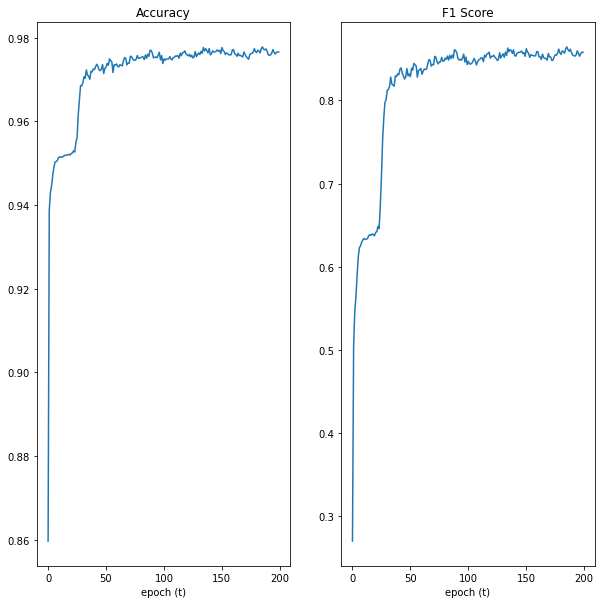

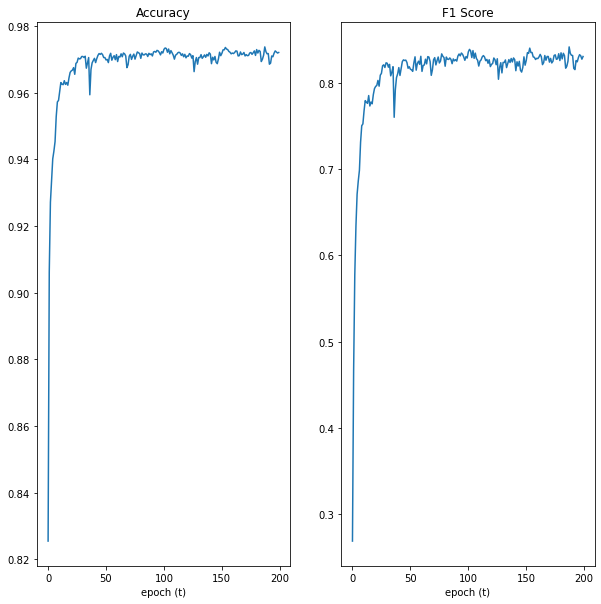

In [11]:
if __name__ == "__main__":
    do_project()

### Linear Smoke Dataset Test

In [12]:
linear_smoke = np.loadtxt("datasets/linearSmoke", delimiter=' ')
linear_smoke[0:5]

array([[0.44585835, 0.118551  , 0.28844605, 0.        ],
       [0.79755534, 0.4674565 , 0.06014127, 1.        ],
       [0.22915307, 0.24377367, 0.28940073, 0.        ],
       [0.46591713, 0.43542925, 0.74361665, 0.        ],
       [0.16873101, 0.588386  , 0.55704835, 0.        ]])

In [13]:
x = linear_smoke[:,:-1]
y = linear_smoke[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [14]:
n_observations, n_variables = np.shape(linear_smoke)

#### Parameters
    Number of Input Variables : n_expl_vars
    Number of Output units : n_target_units
    Hidden Layer Units : hidden_layer_units
    Number of Epochs : n_iterations
    Batch Size Proportion: batch_prop
    Learning Rate : lr

In [15]:
n_expl_vars = n_variables - 1
n_target_units = 1
hidden_layer_units = [2]
n_iterations = 200
batch_prop = 1
lr = 0.05

#### Initialize the Network

In [16]:
NeuralNet = NeuralNetwork(n_expl_vars, hidden_layer_units, n_target_units)

#### Train and Predict the Dataset

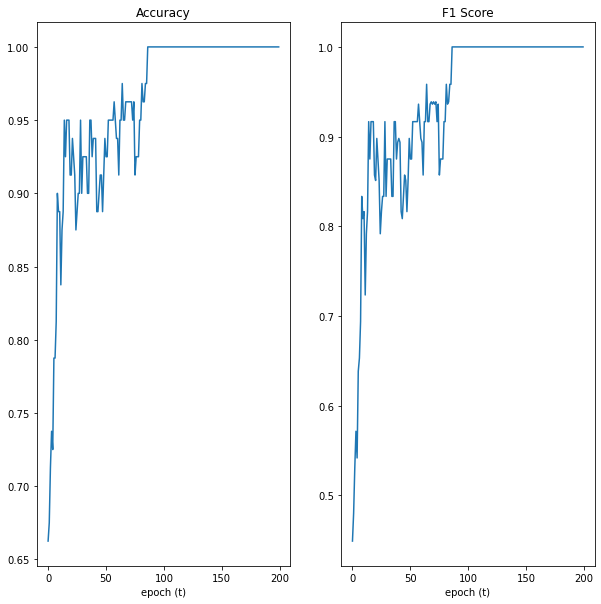

In [17]:
NeuralNet.fit(x_train, y_train, n_iterations, gradient_batch_prop=batch_prop, learning_rate=lr)
y_pred = NeuralNet.predict(x_test)

In [18]:
print(f1_score(y_pred, y_test))
print(accuracy(y_pred, y_test))

1.0
1.0


In [19]:
print(y_pred)
print(y_test)

[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
[0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]


In [20]:
#raise NotImplementedError()

NotImplementedError: 

### Astronomy (HTRU) Dataset Test

In [21]:
htru_train = np.loadtxt("datasets/htru2.train", delimiter=' ')
htru_test = np.loadtxt("datasets/htru2.dev", delimiter=' ')
print(htru_train[0:2],"\n")
print(htru_test[0:2])
print(f"Size of train: {np.shape(htru_train)}")
print(f"Size of test: {np.shape(htru_test)}")

[[1.15085938e+02 4.86322339e+01 6.39753100e-02 7.45754000e-04
  1.34698997e+00 1.23699590e+01 1.23219573e+01 1.89666290e+02
  0.00000000e+00]
 [1.14429688e+02 4.76552862e+01 5.71056540e-02 1.01757662e-01
  7.19481605e+00 3.23738045e+01 4.67602357e+00 2.17049262e+01
  0.00000000e+00]] 

[[ 3.29218750e+01  3.36718097e+01  4.65536077e+00  2.40367114e+01
   3.79991639e+01  6.59160241e+01  1.70029174e+00  1.82294621e+00
   1.00000000e+00]
 [ 1.22648438e+02  4.80922924e+01 -1.59014420e-02 -2.54141288e-01
   1.74832776e+00  1.16158282e+01  1.17885363e+01  2.04472815e+02
   0.00000000e+00]]
Size of train: (12531, 9)
Size of test: (3579, 9)


In [22]:
x_train, y_train = htru_train[:,:-1], htru_train[:,-1]
x_test, y_test = htru_test[:,:-1], htru_test[:,-1]

In [23]:
n_train_observations, n_variables = np.shape(htru_train)

#### Parameters
    Number of Input Variables : n_expl_vars
    Number of Output units : n_target_units
    Hidden Layer Units : hidden_layer_units
    Number of Epochs : n_iterations
    Batch Size Proportion: batch_prop
    Learning Rate : lr

In [24]:
n_expl_vars = n_variables - 1
n_target_units = 1

#### Select Best Network using GridSearch

Train:
0.8380213385063046
0.9733461016678637
Test:
0.8436482084690554
0.9731768650461022
Train:
0.8067226890756302
0.9687973824914212
Test:
0.8053691275167785
0.967588711930707
Train:
0.852082336045955
0.9753411539382332
Test:
0.8354430379746836
0.9709416037999441
Train:
0.7656334964654703
0.9656052988588301
Test:
0.7739602169981916
0.965074043028779
Train:
0.8359102244389028
0.9737451121219376
Test:
0.8448844884488449
0.9737356803576418
Train:
0.8236980410893454
0.9705530284893464
Test:
0.8280254777070063
0.9698239731768651
Train:
0.8495915425276309
0.975021945574974
Test:
0.8301282051282052
0.9703827884884045
Train:
0.8244654400795624
0.9718298619423829
Test:
0.8405315614617941
0.9731768650461022
Train:
0.816235504014273
0.9671215385843109
Test:
0.8373493975903613
0.9698239731768651
Train:
0
0.9112600750139653
Test:
0
0.907236658284437
Train:
0.8568627450980392
0.9766977894820844
Test:
0.8366013071895425
0.9720592344230232
Train:
0.7400976668475312
0.9617747984997207
Test:
0.77718360

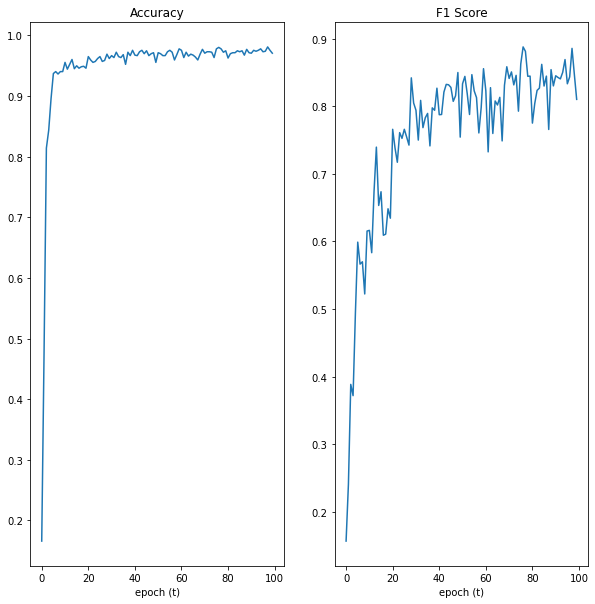

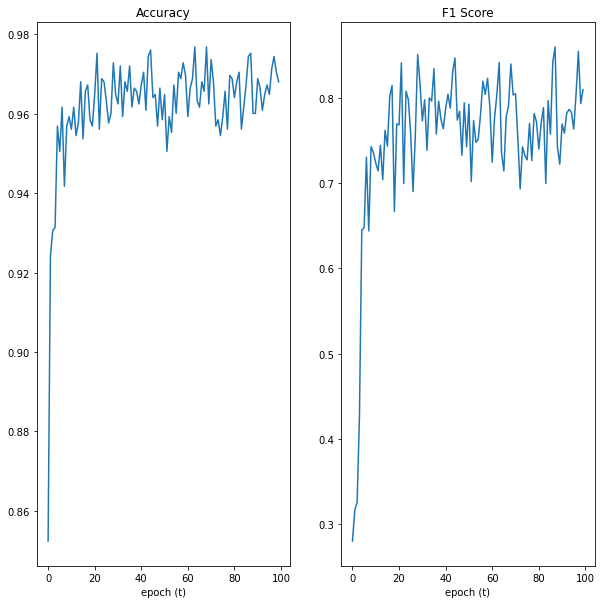

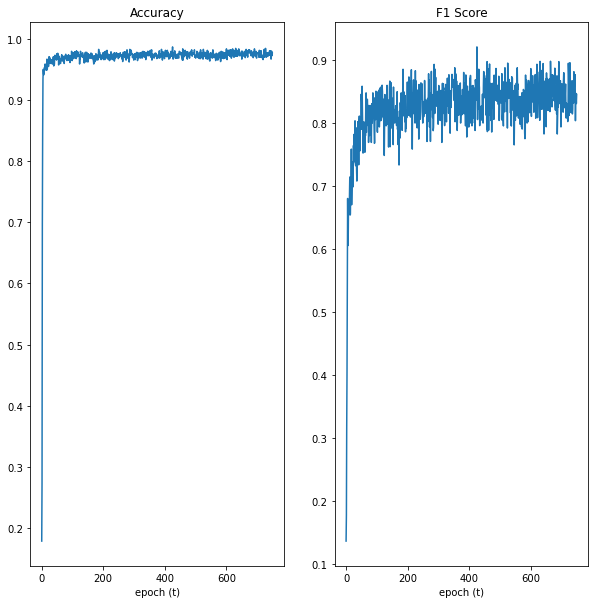

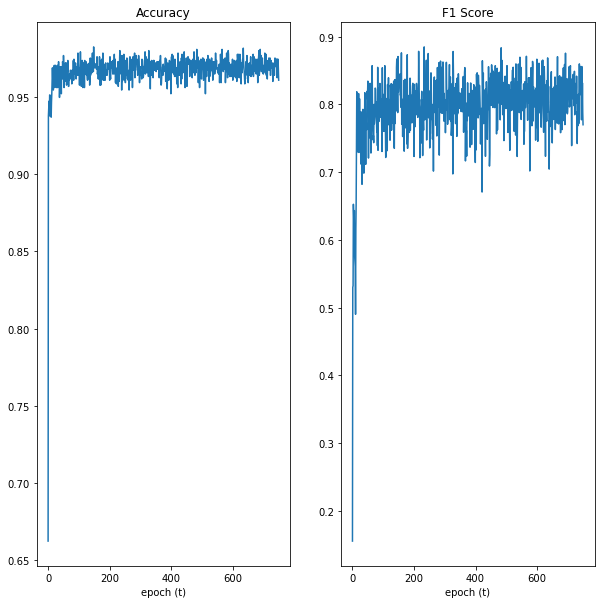

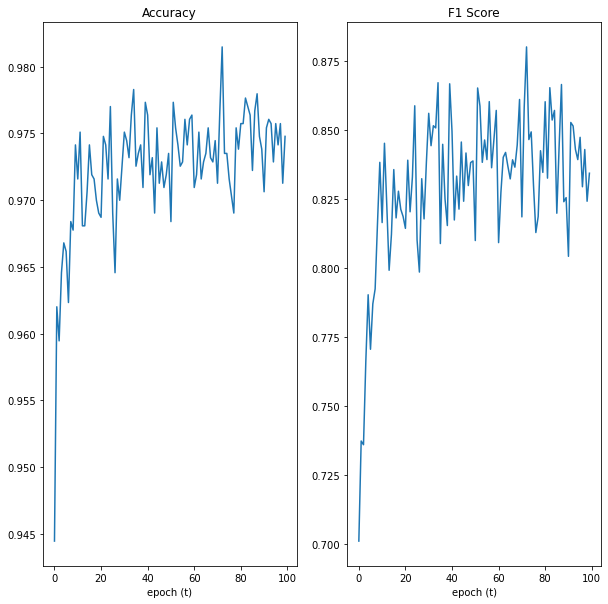

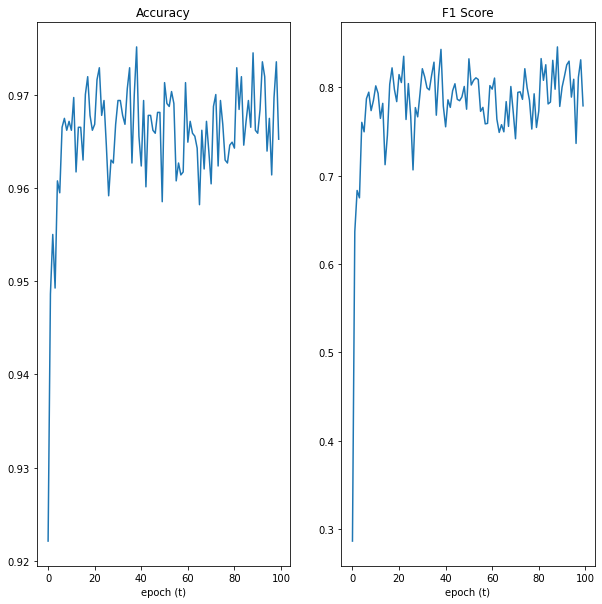

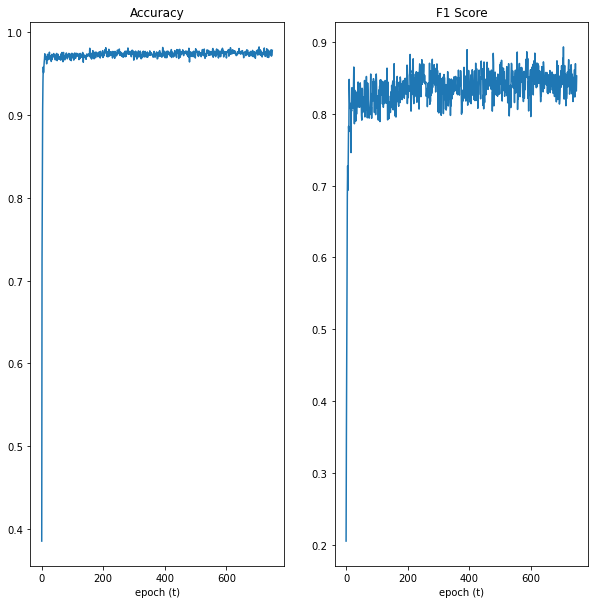

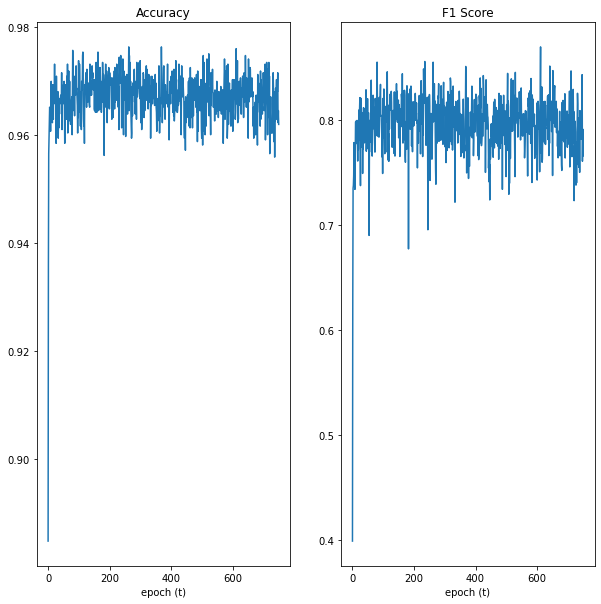

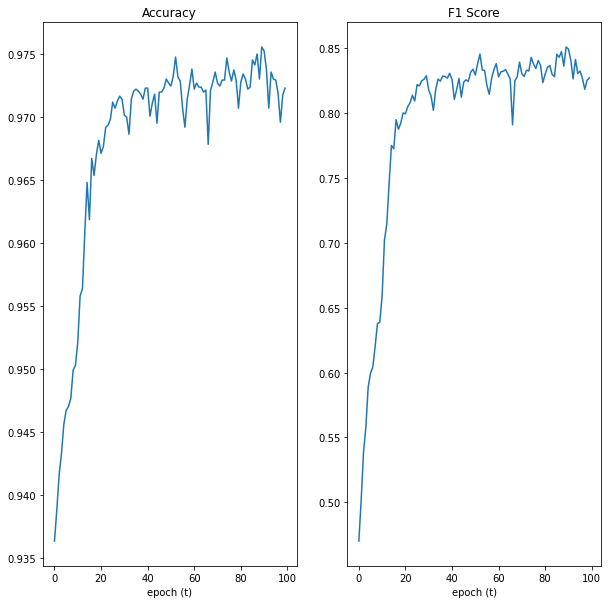

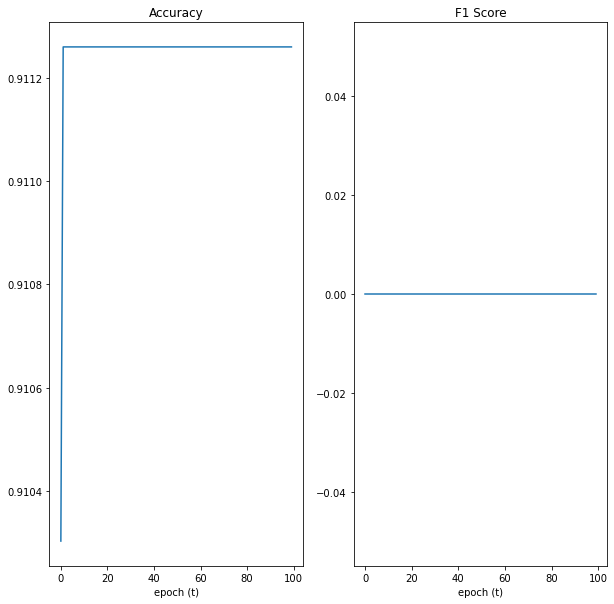

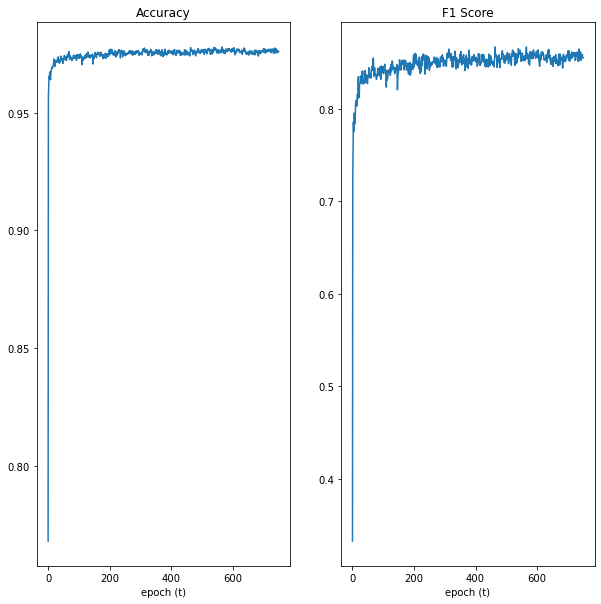

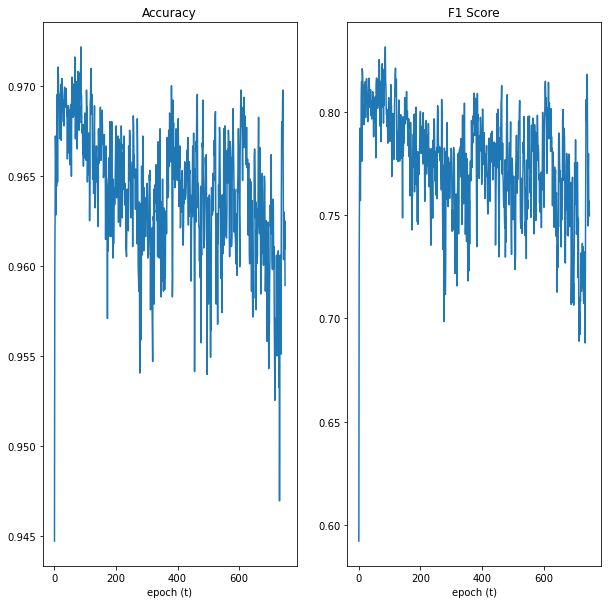

In [26]:
n_iterations_list = [100,750]
hidden_units = [1000]
learning_rates = [0.001, 0.005]
batch_props = [0.1,0.25,1]
for batch_prop in batch_props:
    for n_iterations in n_iterations_list:
        for lr in learning_rates:
            NeuralNet1 = NeuralNetwork(n_expl_vars, hidden_units, n_target_units)
            NeuralNet1.fit(x_train, y_train, n_iterations, gradient_batch_prop=batch_prop, learning_rate = lr)
            y_pred1 = NeuralNet1.predict(x_test)
            y_pred1b = NeuralNet1.predict(x_train)
            
            print(f"Learning Rate: {lr}")
            print(f"Iterations: {n_iterations}")
            print(f"Batch Size Proportion: {batch_prop}")
            
            print("Train:")
            print(f1_score(y_pred1b, y_train))
            print(accuracy(y_pred1b, y_train))
            
            print("Test:")
            print(f1_score(y_pred1, y_test))
            print(accuracy(y_pred1, y_test))

# Order of scores and plots
# batch=0.1,iters=100,lr=.001
# batch=0.1,iters=100,lr=.005

# batch=0.1,iters=750,lr=.001
# batch=0.1,iters=750,lr=.005

# batch=0.25,iters=100,lr=.001
# batch=0.25,iters=100,lr=.005

# batch=0.25,iters=750,lr=.001
# batch=0.25,iters=750,lr=.005

# batch=1,iters=100,lr=.001
# batch=1,iters=100,lr=.005

# batch=1,iters=750,lr=.001
# batch=1,iters=750,lr=.005

Train data set scores:
0.6523454625164401
0.93671694198388
Test data set scores:
0.6626323751891074
0.9376920927633418
Train data set scores:
0.7401101652478718
0.9585827148671295
Test data set scores:
0.7411167512690354
0.9572506286672254
Train data set scores:
0.780607247796278
0.9642486633149788
Test data set scores:
0.7779632721202003
0.9628387817826208
Train data set scores:
0.8007850834151128
0.9676003511291996
Test data set scores:
0.8099173553719008
0.9678681195864767
Train data set scores:
0.7753303964757708
0.9633708403160163
Test data set scores:
0.7569331158238173
0.9583682592903046
Train data set scores:
0.7849794238683129
0.9666427260394223
Test data set scores:
0.797962648556876
0.9667504889633975
Train data set scores:
0.8237566393046836
0.9708722368526055
Test data set scores:
0.8006430868167204
0.9653534506845488
Train data set scores:
0.7419072615923009
0.9529167664192801
Test data set scores:
0.7652173913043478
0.9547359597652976
Train data set scores:
0.81735813066

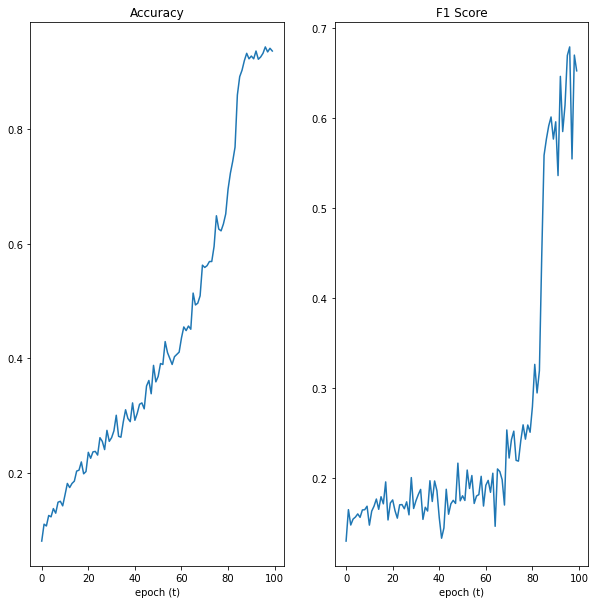

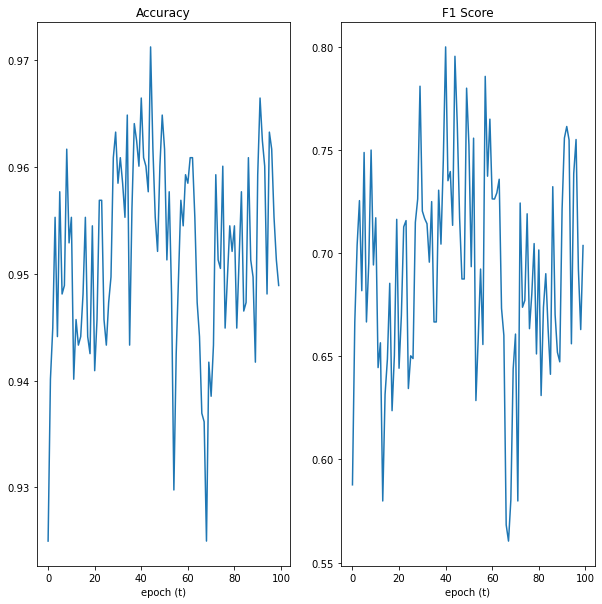

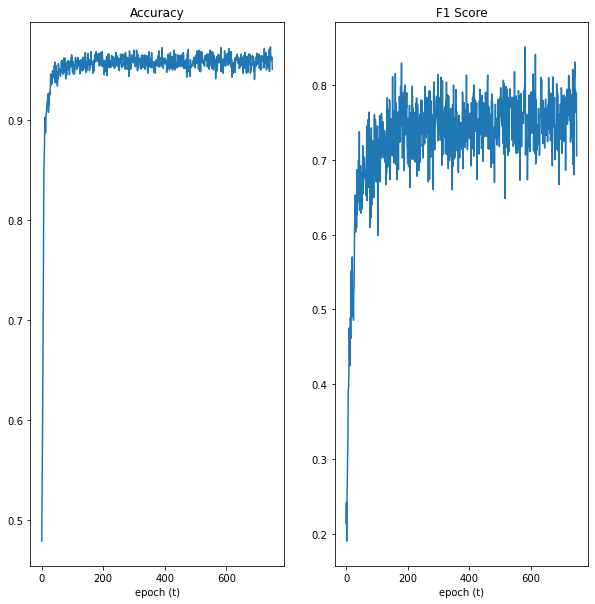

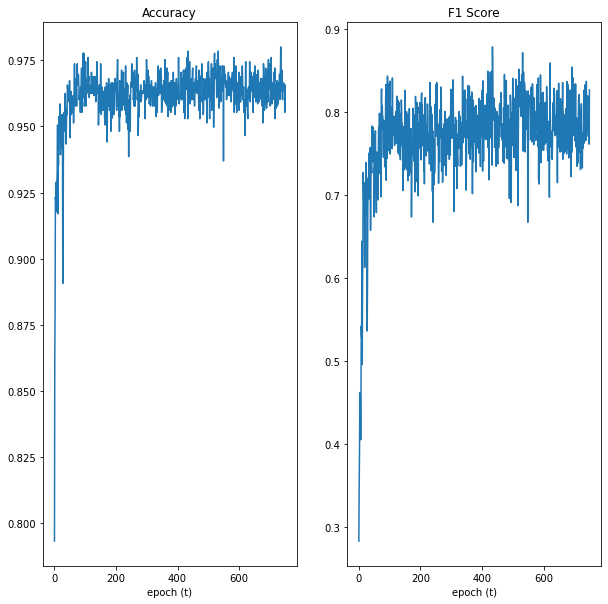

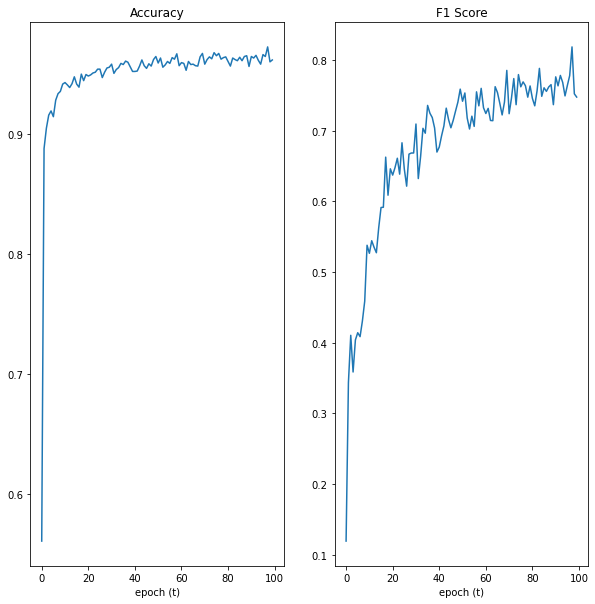

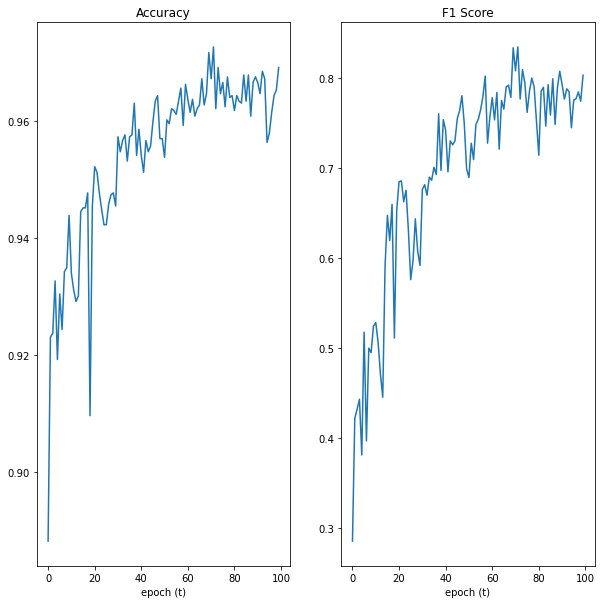

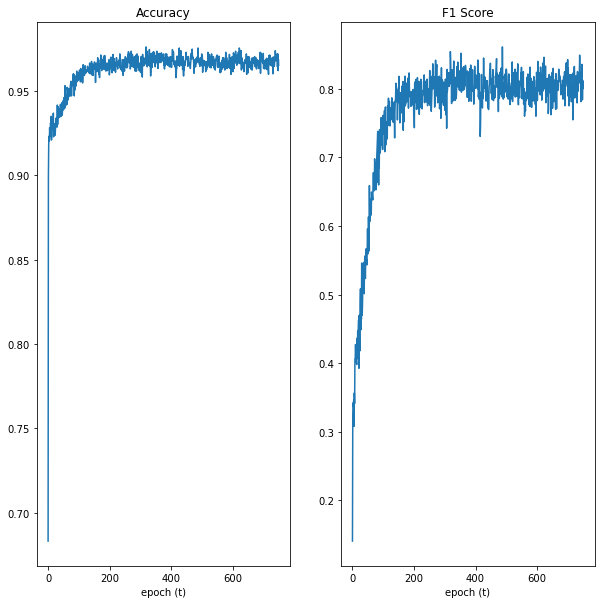

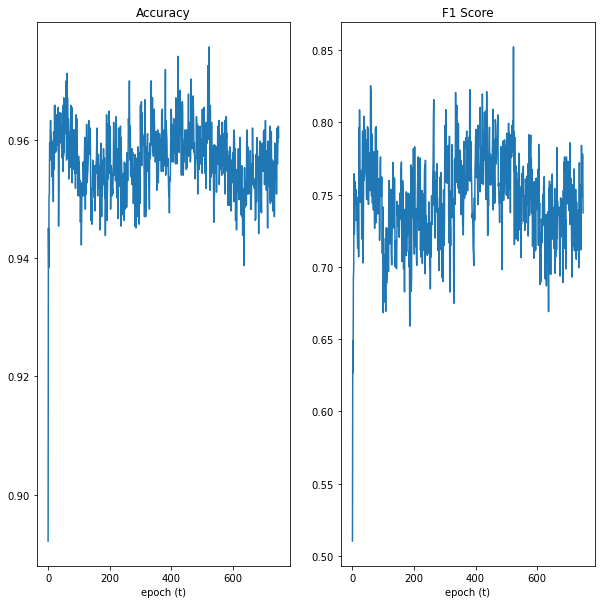

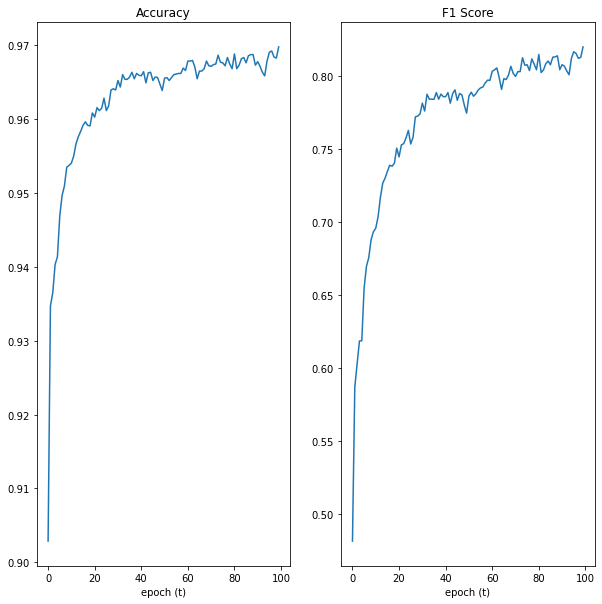

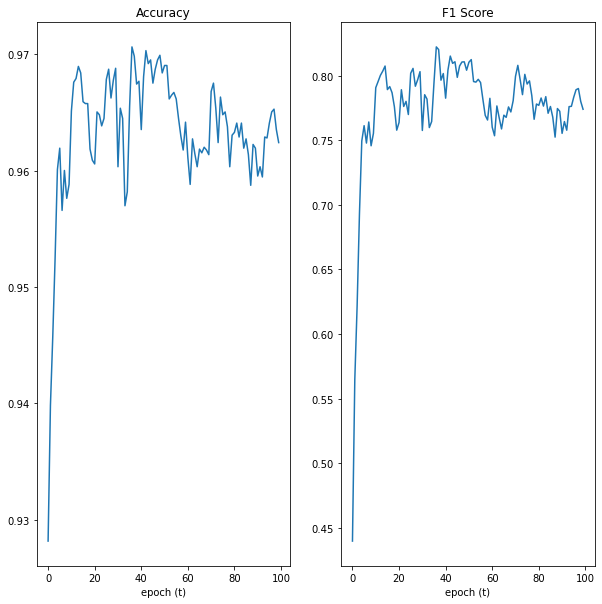

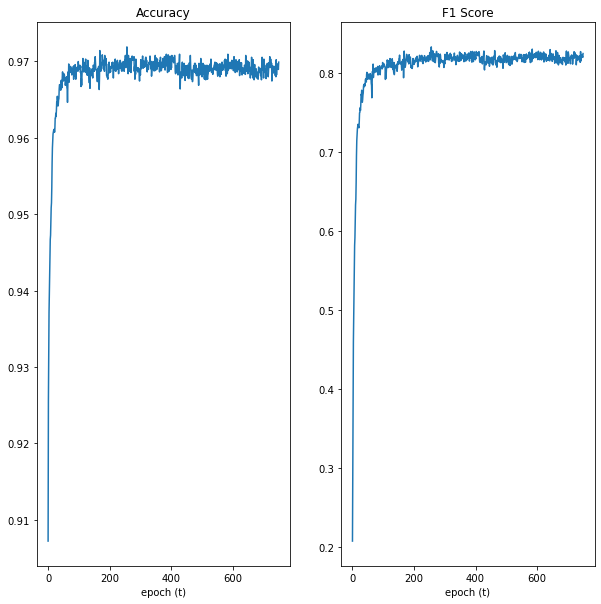

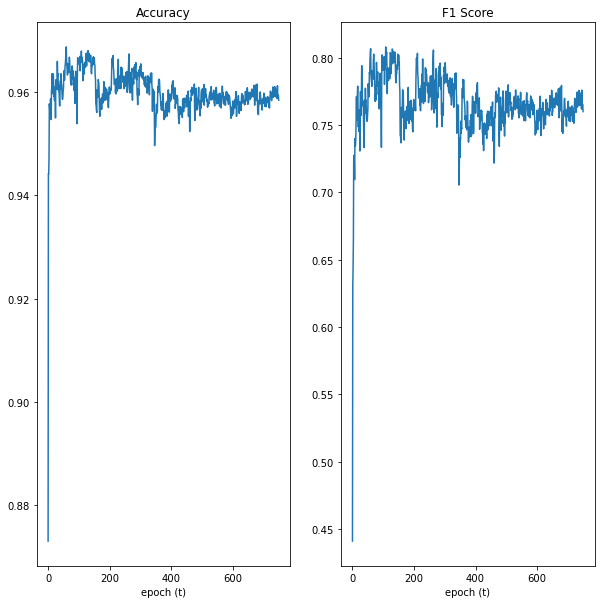

In [27]:
n_iterations_list = [100,750]
hidden_units = [100,100]
learning_rates = [0.0001, 0.0005]
batch_props = [0.1,0.25,1]
for batch_prop in batch_props:
    for n_iterations in n_iterations_list:
        for lr in learning_rates:
        
            NeuralNet3 = NeuralNetwork(n_expl_vars, hidden_units, n_target_units)
            NeuralNet3.fit(x_train, y_train, n_iterations, gradient_batch_prop=batch_prop, learning_rate=lr)
            y_pred3 = NeuralNet3.predict(x_test)
            y_pred3b = NeuralNet3.predict(x_train)

            print(f"Learning Rate: {lr}")
            print(f"Iterations: {n_iterations}")
            print(f"Batch Size Proportion: {batch_prop}")
            
            print("Train:")
            print(f1_score(y_pred3b, y_train))
            print(accuracy(y_pred3b, y_train))
            
            print("Test:")
            print(f1_score(y_pred3, y_test))
            print(accuracy(y_pred3, y_test))

# Order of scores and plots
# batch=0.1,iters=100,lr=.001
# batch=0.1,iters=100,lr=.005

# batch=0.1,iters=750,lr=.001
# batch=0.1,iters=750,lr=.005

# batch=0.25,iters=100,lr=.001
# batch=0.25,iters=100,lr=.005

# batch=0.25,iters=750,lr=.001
# batch=0.25,iters=750,lr=.005

# batch=1,iters=100,lr=.001
# batch=1,iters=100,lr=.005

# batch=1,iters=750,lr=.001
# batch=1,iters=750,lr=.005

if __name__ == "__main__":
    do_project()